In [20]:

from VehicleDetection import VehicleDetection
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import copy
import statistics
from eval_utils import *
from video_utils import *
from load_utils import *
from background_remover import *

data_path = '../../AICity_data/train/S03/c010/'

In [21]:
means, stds = get_background_stats(data_path + 'vdo.avi', 1, 534) # 514 is the 25% of the frames

100%|██████████| 513/513 [00:08<00:00, 57.64it/s]


In [22]:
gt_detect = readDetectionsXML('ai_challenge_s03_c010-full_annotation.xml')

In [23]:
def remove_background_adaptative2(means, stds, videoPath, alpha=4, sigma=2, p=0.1):
    vidcap = cv2.VideoCapture(videoPath)
    num_frames = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
    detections = {}
    for frame in tqdm(range(num_frames)):
        _, image = vidcap.read()
        if frame >= num_frames // 4:
            img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            img_mask = np.zeros(img_gray.shape)
            img_mask[abs(img_gray - means) >= alpha * (stds + sigma)] = 255

            cleaned = cleanMask(img_mask, 7)
            cv2.imwrite(f'./masks_adaptative/mask_{frame}.png', cleaned)

            #update mean and std
            idxs = cleaned == 0
            means[idxs] = p * img_gray[idxs] + (1 - p) * means[idxs]
            stds[idxs] = np.sqrt(p * (img_gray[idxs] - means[idxs])**2 + (1 - p) * stds[idxs]**2)

            detections[str(frame)] = getBoxesFromMask(cleaned)

    return detections

In [15]:
print(np.min(stds),np.max(stds))

0.0 42.98780713802363


In [24]:
singleGaussianDetections = remove_background_adaptative2(means,stds, data_path + 'vdo.avi',4,2,0.07)

100%|██████████| 2141/2141 [04:37<00:00,  7.72it/s]


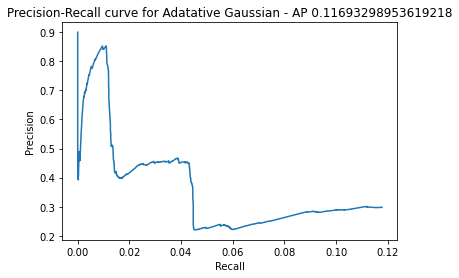

In [25]:
recs, precs, aps = ap_wo_conf(gt_detect,singleGaussianDetections)
plot_prec_recall_curve(np.mean(precs, axis=0), recs[0], f'Precision-Recall curve for Adatative Gaussian - AP {np.mean(aps)}')